# Plot ESMBind Metrics


In [1]:
# basic
import os
import re
import sys
import pickle 
import numpy as np
import pandas as pd
import os.path as osp
from loguru import logger
from pathlib import Path
from pprint import pprint
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Mapping, Set
# metrics 
from sklearn.metrics import (
    matthews_corrcoef, 
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score)

# Metrics 

In [2]:
BASE=Path("/home/chunan/UCL/scripts/Antibody-specific-epitope-prediction-2.0/experiments/esmbind")
RESULTS=BASE/"fine-tuned-esmbind-inference-performance"/"r2"
LABELS=BASE/'abag_dataset'/'processed'/'fine-tune-input'/'labels.pkl'

In [3]:
# 0. load results 
with open(RESULTS/'result.pkl', 'rb') as f:
    results = pickle.load(f)

In [4]:
# 1. load abdbids and labels 
with open(LABELS.parent / 'abdbids.txt', 'r') as f:
    abdbids = [line.strip() for line in f.readlines()]
    
with open(LABELS, 'rb') as f:
    labels = pickle.load(f)

In [5]:
all = {'abdbid': [], 'mcc': [], 'aucroc': [], 'precision': [], 'recall': [], 'f1': []}

# 2. calculate mcc metrics 
warn_items_num = 0
warn_items = {'abdbid': [], 'idx': []}
for i, (abdbid, x, y) in enumerate(zip(abdbids, labels, results)):
    if len(x) == len(y['preds']):
        all['abdbid'].append(abdbid)
        all['mcc'].append(matthews_corrcoef(x, y['preds']))
        all['aucroc'].append(roc_auc_score(x, y['preds']))
        all['precision'].append(precision_score(x, y['preds']))
        all['recall'].append(recall_score(x, y['preds']))
        all['f1'].append(f1_score(x, y['preds']))
    else:
        # warning that a sample may have exceeded the max length the model can accept 
        logger.warning(f"Warning: a sample has length {len(x)} that exceeds the max length 1024 the model can accept:\n{y['raw_seq']}\n")
        warn_items_num += 1
        warn_items['idx'].append(i)
        warn_items['abdbid'].append(abdbid)
print(warn_items_num)  # 145 

/home/chunan/miniconda3/envs/py311-graphein-dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-11-29 15:11:32.600 | WARNING  | __main__:<module>:16 - Warning: a sample has length 1134 that exceeds the max length 1024 the model can accept:
QCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKN

/home/chunan/miniconda3/envs/py311-graphein-dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chunan/miniconda3/envs/py311-graphein-dev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-11-29 15:11:32.748 | WARNING  | __main__:<module>:16 - Warning: a sample has length 1130 that exceeds the max length 1024 the model can accept:
CVNFTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFANPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTP

145


## Plot 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Set2")

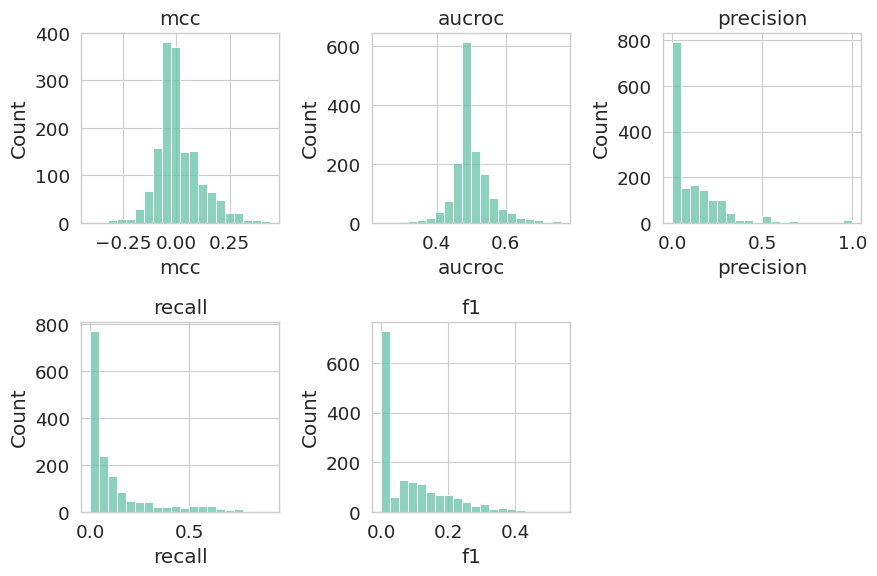

In [7]:
# plot metrics as histogram 
fig, ax = plt.subplots(2, 3, figsize=(9, 6))#, sharex=True, sharey=True)
# create bin between -1 and 1 using np 
for i, k in enumerate(['mcc', 'aucroc', 'precision', 'recall', 'f1']):
    sns.histplot(data=all, x=k, bins=20, ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title(k)
    # ax[i//3][i%3].tick_params(axis="x", bottom=True, labelbottom=True)
# remove the last plot
ax[1][2].remove()
fig.tight_layout()
fig.show()
fig.savefig('plots/metrics-hist.pdf', dpi=300)

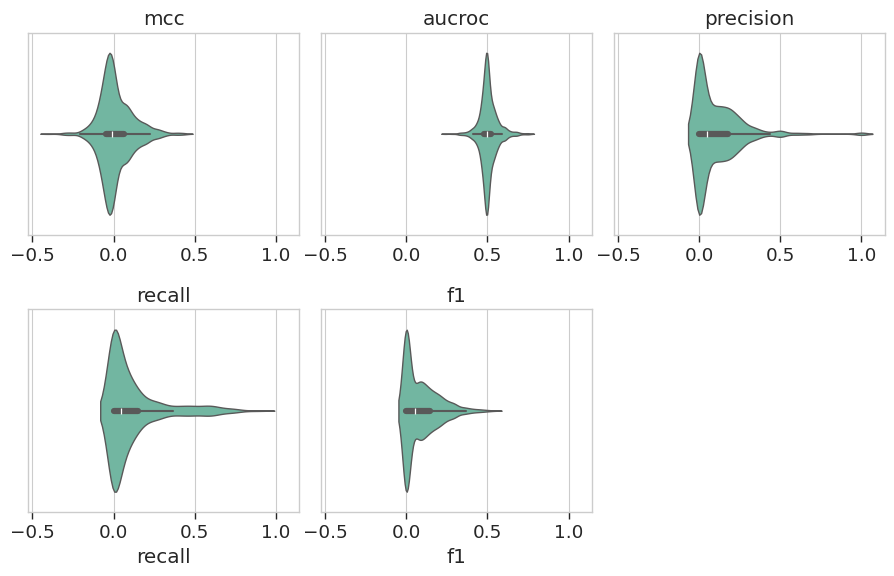

In [8]:
# violin plot 
fig, ax = plt.subplots(2, 3, figsize=(9, 6), sharex=True)
for i, k in enumerate(['mcc', 'aucroc', 'precision', 'recall', 'f1']):
    sns.violinplot(data=all, x=k, ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title(k)
    # show xticks 
    ax[i//3][i%3].tick_params(axis="x", bottom=True, labelbottom=True)

# remove the last plot
ax[1][2].remove()
fig.tight_layout()
fig.show()
fig.savefig('plots/metrics-violine.pdf', dpi=300)

## Test set performance 

In [9]:
# torch tools
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch_scatter as ts
from torch import Tensor

In [10]:
split_idx = torch.load("/home/chunan/UCL/scripts/Antibody-specific-epitope-prediction-2.0/data/asepv1/split/split_dict.pt")
with open("/home/chunan/UCL/scripts/Antibody-specific-epitope-prediction-2.0/data/asepv1/raw/asepv1-graphs.txt") as f:
    asepv1_abdbids = [line.strip() for line in f.readlines()]

In [11]:
test_set_abdbids  = np.array(asepv1_abdbids)[split_idx['test'].tolist()]
val_set_abdbids   = np.array(asepv1_abdbids)[split_idx['valid'].tolist()]
train_set_abdbids = np.array(asepv1_abdbids)[split_idx['train'].tolist()]
abdbid2set = {}
for abdbid in abdbids:
    if abdbid in test_set_abdbids:
        abdbid2set[abdbid] = 'test'
    elif abdbid in val_set_abdbids:
        abdbid2set[abdbid] = 'val'
    elif abdbid in train_set_abdbids:
        abdbid2set[abdbid] = 'train'
    else:
        raise ValueError(f"abdbid {abdbid} not found in any set")

In [12]:
# derive metrics from all using abdbids 
all_df = pd.DataFrame(all)
all_df['set'] = all_df['abdbid'].map(abdbid2set)

In [13]:
test_set_metric_df = all_df[all_df['set'] == 'test']

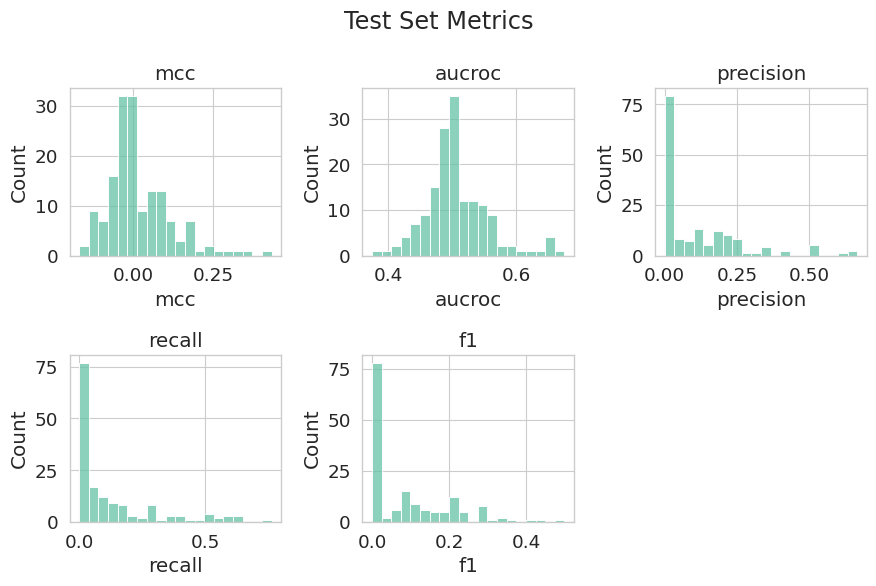

In [14]:
# plot metrics as histogram
fig, ax = plt.subplots(2, 3, figsize=(9, 6))#, sharex=True, sharey=True)
# create bin between -1 and 1 using np
for i, k in enumerate(['mcc', 'aucroc', 'precision', 'recall', 'f1']):
    sns.histplot(data=test_set_metric_df, x=k, bins=20, ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title(k)
    # ax[i//3][i%3].tick_params(axis="x", bottom=True, labelbottom=True)
# add super title
fig.suptitle("Test Set Metrics")
# remove the last plot
ax[1][2].remove()
fig.tight_layout()
fig.show()
fig.savefig('plots/metrics-hist-testset.pdf', dpi=300)

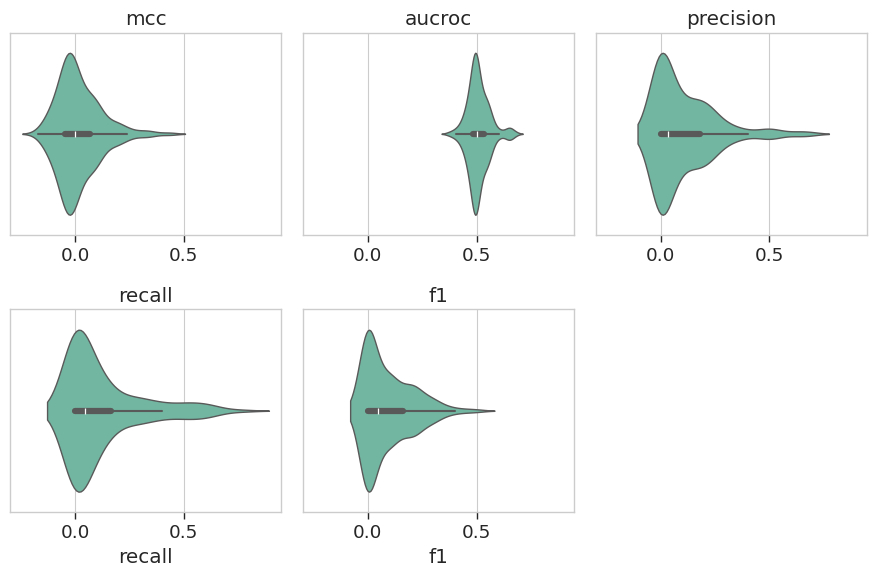

In [15]:
# violin plot
fig, ax = plt.subplots(2, 3, figsize=(9, 6), sharex=True)
for i, k in enumerate(['mcc', 'aucroc', 'precision', 'recall', 'f1']):
    sns.violinplot(data=test_set_metric_df, x=k, ax=ax[i//3][i%3])
    ax[i//3][i%3].set_title(k)
    # show xticks
    ax[i//3][i%3].tick_params(axis="x", bottom=True, labelbottom=True)
# remove the last plot
ax[1][2].remove()
fig.tight_layout()
fig.show()
fig.savefig('plots/metrics-violine-testset.pdf', dpi=300)

In [16]:
test_set_metric_df.describe()

,mcc,aucroc,precision,recall,f1
count,158.000000,158.000000,158.000000,158.000000,158.000000
mean,0.016432,0.506307,0.106340,0.120693,0.089874
std,0.100430,0.049733,0.146361,0.177263,0.112223
min,-0.169528,0.374737,0.000000,0.000000,0.000000
25%,-0.044563,0.481292,0.000000,0.000000,0.000000
50%,-0.001308,0.499496,0.034144,0.047727,0.044532
75%,0.069301,0.534018,0.181818,0.165323,0.163491
max,0.432151,0.675410,0.666667,0.761905,0.500000


In [18]:
# find failed test abdbids 
failed_test_abdbids = set(test_set_abdbids) - set(test_set_metric_df['abdbid'])
print(f"{len(failed_test_abdbids)} failed test abdbids: {', '.join(failed_test_abdbids)}")

12 failed test abdbids: 7ls9_0P, 7cyp_0P, 7zrc_0P, 7zr9_0P, 7v23_0P, 7lxz_1P, 7ru5_0P, 7k8x_0P, 7m6f_1P, 7t3m_0P, 7woa_0P, 6xcm_0P
